# 마운트 및 설치

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install wfdb
!pip install hrv

# 데이터 전처리

In [ ]:
data_path = '/content/drive/MyDrive/디지털헬스케어/apnea-ecg-database-1.0.0/'

In [ ]:
# https://github.com/pss1207/sleep_apnea/

import wfdb
import matplotlib.pyplot as plt
import numpy as np
from hrv.filters import quotient, moving_median
from scipy import interpolate
from tqdm import tqdm
import pickle
import os

FS = 100.0  # 샘플링 주파수 (100 Hz)

# From https://github.com/rhenanbartels/hrv/blob/develop/hrv/classical.py
# RRI를 초 단위로 변환한 시간 정보 생성
def create_time_info(rri):
    rri_time = np.cumsum(rri) / 1000.0  # 밀리초 단위로 변환 후, 누적 합산하여 시간 정보 생성
    return rri_time - rri_time[0]  # 시간 정보를 0부터 시작하도록 조정

# RRI의 시간 정보를 기반으로 일정한 주파수로 보간할 시간 축 생성
def create_interp_time(rri, fs):
    time_rri = create_time_info(rri)
    return np.arange(0, time_rri[-1], 1 / float(fs))  # 일정한 주파수의 시간 축 생성

# RRI에 대해 3차 스플라인 보간 수행
def interp_cubic_spline(rri, fs):
    time_rri = create_time_info(rri)
    time_rri_interp = create_interp_time(rri, fs)
    tck = interpolate.splrep(time_rri, rri, s=0)  # 3차 스플라인 함수 생성
    rri_interp = interpolate.splev(time_rri_interp, tck, der=0)  # 보간된 RRI 반환
    return time_rri_interp, rri_interp

# QRS 주석에 대해 진폭을 3차 스플라인 보간하여 반환
def interp_cubic_spline_qrs(qrs_index, qrs_amp, fs):
    time_qrs = qrs_index / float(FS)  # QRS 위치를 초 단위로 변환
    time_qrs = time_qrs - time_qrs[0]  # 시간 정보를 0부터 시작하도록 조정
    time_qrs_interp = np.arange(0, time_qrs[-1], 1 / float(fs))  # 일정한 주파수의 시간 축 생성
    tck = interpolate.splrep(time_qrs, qrs_amp, s=0)  # 3차 스플라인 함수 생성
    qrs_interp = interpolate.splev(time_qrs_interp, tck, der=0)  # 보간된 QRS 진폭 반환
    return time_qrs_interp, qrs_interp

# 학습 데이터, 검증 데이터, 테스트 데이터에 해당하는 환자들
train_data_name = ['a02', 'a03', 'a04', 'a05',
                   'a06', 'a07', 'a08', 'a09', 'a10',
                   'a11', 'a12', 'a13', 'a14', 'a15',
                   'a16', 'a17', 'a18', 'a19',
                   'b02', 'b03', 'b04',
                   'c02', 'c03', 'c04', 'c05',
                   'c06', 'c07', 'c08', 'c09',]
val_data_name = ['a01', 'b01', 'c01']
test_data_name = ['a20', 'b05', 'c10']

# 연령과 성별 정보
train_age = [38, 54, 52, 58,
             63, 44, 51, 52, 58,
             58, 52, 51, 51, 60,
             44, 40, 52, 55,
             53, 53, 42,
             37, 39, 41, 28,
             28, 30, 42, 37]
# (1: 남성, 0: 여성)
train_sex = [1, 1, 1, 1,
             1, 1, 1, 1, 1,
             1, 1, 1, 1, 1,
             1, 1, 1, 1,
             1, 1, 1,
             1, 1, 0, 0,
             0, 0, 1, 1]

val_age = [51, 44, 31]
val_sex = [1, 0, 1]

test_age = [58, 52, 27]
test_sex = [1, 1, 1]


# QRS 검출 시 진폭을 계산하는 함수
def get_qrs_amp(ecg, qrs):
    interval = int(FS * 0.250)  # QRS 복합체 주변 250ms의 범위로 진폭 계산
    qrs_amp = []
    for index in range(len(qrs)):
        curr_qrs = qrs[index]
        amp = np.max(ecg[curr_qrs-interval:curr_qrs+interval])  # QRS 복합체 진폭 계산
        qrs_amp.append(amp)

    return qrs_amp

MARGIN = 10  # 데이터 윈도우의 여유 margin (초 단위)
FS_INTP = 4  # 보간할 새로운 샘플링 주파수 (4 Hz)
MAX_HR = 300.0  # 최대 심박수 (bpm)
MIN_HR = 20.0  # 최소 심박수 (bpm)
MIN_RRI = 1.0 / (MAX_HR / 60.0) * 1000  # 최소 RRI (밀리초)
MAX_RRI = 1.0 / (MIN_HR / 60.0) * 1000  # 최대 RRI (밀리초)

# 훈련 데이터 배열 초기화
train_input_array = []
train_label_array = []

# 훈련 데이터 생성
for data_index in range(len(train_data_name)):
    print(train_data_name[data_index])
    win_num = len(wfdb.rdann(os.path.join(data_path, train_data_name[data_index]), 'apn').symbol)  # 데이터 윈도우의 개수
    signals, fields = wfdb.rdsamp(os.path.join(data_path, train_data_name[data_index]))  # ECG 신호 읽기
    for index in tqdm(range(1, win_num)):
        samp_from = index * 60 * FS  # 60초 간격으로 데이터 구간 설정
        samp_to = samp_from + 60 * FS  # 60초 간격으로 데이터 구간 설정

        qrs_ann = wfdb.rdann(data_path + train_data_name[data_index], 'qrs', sampfrom=samp_from - (MARGIN*100), sampto=samp_to + (MARGIN*100)).sample  # QRS 주석
        apn_ann = wfdb.rdann(data_path + train_data_name[data_index], 'apn', sampfrom=samp_from, sampto=samp_to-1).symbol  # 아프네아 주석

        qrs_amp = get_qrs_amp(signals, qrs_ann)  # QRS 진폭 계산

        rri = np.diff(qrs_ann)  # RRI 계산
        rri_ms = rri.astype('float') / FS * 1000.0  # RRI를 밀리초 단위로 변환
        try:
            rri_filt = moving_median(rri_ms)  # RRI 필터링 (이동 중앙값 필터 사용)

            # 필터링된 RRI가 조건을 만족하면 보간 수행
            if len(rri_filt) > 5 and (np.min(rri_filt) >= MIN_RRI and np.max(rri_filt) <= MAX_RRI):
                time_intp, rri_intp = interp_cubic_spline(rri_filt, FS_INTP)  # RRI 보간
                qrs_time_intp, qrs_intp = interp_cubic_spline_qrs(qrs_ann, qrs_amp, FS_INTP)  # QRS 진폭 보간
                rri_intp = rri_intp[(time_intp >= MARGIN) & (time_intp < (60 + MARGIN))]  # 60초 구간으로 제한
                qrs_intp = qrs_intp[(qrs_time_intp >= MARGIN) & (qrs_time_intp < (60 + MARGIN))]  # 60초 구간으로 제한

                if len(rri_intp) != (FS_INTP * 60):  # 60초 분량의 데이터가 아닌 경우 skip
                    skip = 1
                else:
                    skip = 0

                if skip == 0:
                    rri_intp = rri_intp - np.mean(rri_intp)  # RRI의 평균을 0으로 맞춤
                    qrs_intp = qrs_intp - np.mean(qrs_intp)  # QRS 진폭의 평균을 0으로 맞춤

                    # 라벨 설정 (N: 정상, A: 아프네아)
                    if apn_ann[0] == 'N':  # 정상
                        label = 0.0
                    elif apn_ann[0] == 'A':  # 아프네아
                        label = 1.0
                    else:
                        label = 2.0  # 다른 상태 (예: 비정상)

                    # 훈련 데이터를 입력 배열에 추가
                    train_input_array.append([rri_intp, qrs_intp, train_age[data_index], train_sex[data_index]])
                    train_label_array.append(label)  # 라벨도 함께 추가
        except:
            hrv_module_error = 1  # 예외 발생 시 오류 처리

# 훈련 데이터와 라벨을 pickle 파일로 저장
with open('/content/drive/MyDrive/디지털헬스케어/train_input.pickle', 'wb') as f:
    pickle.dump(train_input_array, f)
with open('/content/drive/MyDrive/디지털헬스케어/train_label.pickle', 'wb') as f:
    pickle.dump(train_label_array, f)


# 검증 데이터 준비
val_input_array = []
val_label_array = []
for data_index in range(len(val_data_name)):
    print(val_data_name[data_index])
    win_num = len(wfdb.rdann(os.path.join(data_path, val_data_name[data_index]), 'apn').symbol)  # 데이터 윈도우의 개수
    signals, fields = wfdb.rdsamp(os.path.join(data_path, val_data_name[data_index]))  # ECG 신호 읽기
    for index in tqdm(range(1, win_num)):
        samp_from = index * 60 * FS  # 60초 간격으로 데이터 구간 설정
        samp_to = samp_from + 60 * FS  # 60초 간격으로 데이터 구간 설정

        qrs_ann = wfdb.rdann(data_path + val_data_name[data_index], 'qrs', sampfrom=samp_from - (MARGIN*100), sampto=samp_to + (MARGIN*100)).sample  # QRS 주석
        apn_ann = wfdb.rdann(data_path + val_data_name[data_index], 'apn', sampfrom=samp_from, sampto=samp_to-1).symbol  # 아프네아 주석

        qrs_amp = get_qrs_amp(signals, qrs_ann)  # QRS 진폭 계산

        rri = np.diff(qrs_ann)  # RRI 계산
        rri_ms = rri.astype('float') / FS * 1000.0  # RRI를 밀리초 단위로 변환
        try:
            rri_filt = moving_median(rri_ms)  # RRI 필터링 (이동 중앙값 필터 사용)

            # 필터링된 RRI가 조건을 만족하면 보간 수행
            if len(rri_filt) > 5 and (np.min(rri_filt) >= MIN_RRI and np.max(rri_filt) <= MAX_RRI):
                time_intp, rri_intp = interp_cubic_spline(rri_filt, FS_INTP)  # RRI 보간
                qrs_time_intp, qrs_intp = interp_cubic_spline_qrs(qrs_ann, qrs_amp, FS_INTP)  # QRS 진폭 보간
                rri_intp = rri_intp[(time_intp >= MARGIN) & (time_intp < (60 + MARGIN))]  # 60초 구간으로 제한
                qrs_intp = qrs_intp[(qrs_time_intp >= MARGIN) & (qrs_time_intp < (60 + MARGIN))]  # 60초 구간으로 제한

                if len(rri_intp) != (FS_INTP * 60):  # 60초 분량의 데이터가 아닌 경우 skip
                    skip = 1
                else:
                    skip = 0

                if skip == 0:
                    rri_intp = rri_intp - np.mean(rri_intp)  # RRI의 평균을 0으로 맞춤
                    qrs_intp = qrs_intp - np.mean(qrs_intp)  # QRS 진폭의 평균을 0으로 맞춤

                    # 라벨 설정 (N: 정상, A: 아프네아)
                    if apn_ann[0] == 'N':  # 정상
                        label = 0.0
                    elif apn_ann[0] == 'A':  # 아프네아
                        label = 1.0
                    else:
                        label = 2.0  # 다른 상태 (예: 비정상)

                    # 검증 데이터를 입력 배열에 추가
                    val_input_array.append([rri_intp, qrs_intp, val_age[data_index], val_sex[data_index]])
                    val_label_array.append(label)  # 라벨도 함께 추가
        except:
            hrv_module_error = 1  # 예외 발생 시 오류 처리

# 검증 데이터와 라벨을 pickle 파일로 저장
with open('/content/drive/MyDrive/디지털헬스케어/val_input.pickle', 'wb') as f:
    pickle.dump(val_input_array, f)
with open('/content/drive/MyDrive/디지털헬스케어/val_label.pickle', 'wb') as f:
    pickle.dump(val_label_array, f)


# 테스트 데이터 준비
test_input_array = []
test_label_array = []
for data_index in range(len(test_data_name)):
    print(test_data_name[data_index])
    win_num = len(wfdb.rdann(os.path.join(data_path, test_data_name[data_index]), 'apn').symbol)  # 데이터 윈도우의 개수
    signals, fields = wfdb.rdsamp(os.path.join(data_path, test_data_name[data_index]))  # ECG 신호 읽기
    for index in tqdm(range(1, win_num)):
        samp_from = index * 60 * FS  # 60초 간격으로 데이터 구간 설정
        samp_to = samp_from + 60 * FS  # 60초 간격으로 데이터 구간 설정

        qrs_ann = wfdb.rdann(data_path + test_data_name[data_index], 'qrs', sampfrom=samp_from - (MARGIN*100), sampto=samp_to + (MARGIN*100)).sample  # QRS 주석
        apn_ann = wfdb.rdann(data_path + test_data_name[data_index], 'apn', sampfrom=samp_from, sampto=samp_to-1).symbol  # 아프네아 주석

        qrs_amp = get_qrs_amp(signals, qrs_ann)  # QRS 진폭 계산

        rri = np.diff(qrs_ann)  # RRI 계산
        rri_ms = rri.astype('float') / FS * 1000.0  # RRI를 밀리초 단위로 변환
        try:
            rri_filt = moving_median(rri_ms)  # RRI 필터링 (이동 중앙값 필터 사용)

            # 필터링된 RRI가 조건을 만족하면 보간 수행
            if len(rri_filt) > 5 and (np.min(rri_filt) >= MIN_RRI and np.max(rri_filt) <= MAX_RRI):
                time_intp, rri_intp = interp_cubic_spline(rri_filt, FS_INTP)  # RRI 보간
                qrs_time_intp, qrs_intp = interp_cubic_spline_qrs(qrs_ann, qrs_amp, FS_INTP)  # QRS 진폭 보간
                rri_intp = rri_intp[(time_intp >= MARGIN) & (time_intp < (60 + MARGIN))]  # 60초 구간으로 제한
                qrs_intp = qrs_intp[(qrs_time_intp >= MARGIN) & (qrs_time_intp < (60 + MARGIN))]  # 60초 구간으로 제한

                if len(rri_intp) != (FS_INTP * 60):  # 60초 분량의 데이터가 아닌 경우 skip
                    skip = 1
                else:
                    skip = 0

                if skip == 0:
                    rri_intp = rri_intp - np.mean(rri_intp)  # RRI의 평균을 0으로 맞춤
                    qrs_intp = qrs_intp - np.mean(qrs_intp)  # QRS 진폭의 평균을 0으로 맞춤

                    # 라벨 설정 (N: 정상, A: 아프네아)
                    if apn_ann[0] == 'N':  # 정상
                        label = 0.0
                    elif apn_ann[0] == 'A':  # 아프네아
                        label = 1.0
                    else:
                        label = 2.0  # 다른 상태 (예: 비정상)

                    # 테스트 데이터를 입력 배열에 추가
                    test_input_array.append([rri_intp, qrs_intp, test_age[data_index], test_sex[data_index]])
                    test_label_array.append(label)  # 라벨도 함께 추가
        except:
            hrv_module_error = 1  # 예외 발생 시 오류 처리

# 테스트 데이터와 라벨을 pickle 파일로 저장
with open('/content/drive/MyDrive/디지털헬스케어/test_input.pickle', 'wb') as f:
    pickle.dump(test_input_array, f)
with open('/content/drive/MyDrive/디지털헬스케어/test_label.pickle', 'wb') as f:
    pickle.dump(test_label_array, f)


a02


100%|██████████| 527/527 [02:25<00:00,  3.62it/s]


a03


100%|██████████| 518/518 [02:19<00:00,  3.71it/s]


a04


100%|██████████| 491/491 [02:00<00:00,  4.07it/s]


a05


100%|██████████| 453/453 [01:44<00:00,  4.35it/s]


a06


100%|██████████| 509/509 [01:50<00:00,  4.60it/s]


a07


100%|██████████| 510/510 [02:23<00:00,  3.56it/s]


a08


100%|██████████| 500/500 [02:35<00:00,  3.22it/s]


a09


100%|██████████| 494/494 [01:59<00:00,  4.15it/s]


a10


100%|██████████| 516/516 [02:05<00:00,  4.11it/s]


a11


100%|██████████| 465/465 [01:55<00:00,  4.04it/s]


a12


100%|██████████| 576/576 [02:32<00:00,  3.77it/s]


a13


100%|██████████| 494/494 [02:28<00:00,  3.32it/s]


a14


100%|██████████| 508/508 [01:51<00:00,  4.55it/s]


a15


100%|██████████| 509/509 [02:08<00:00,  3.96it/s]


a16


100%|██████████| 481/481 [02:09<00:00,  3.73it/s]


a17


100%|██████████| 484/484 [02:14<00:00,  3.59it/s]


a18


100%|██████████| 488/488 [01:56<00:00,  4.20it/s]


a19


100%|██████████| 501/501 [02:24<00:00,  3.46it/s]


b02


100%|██████████| 516/516 [02:21<00:00,  3.65it/s]


b03


100%|██████████| 440/440 [01:40<00:00,  4.36it/s]


b04


100%|██████████| 428/428 [01:24<00:00,  5.09it/s]


c02


100%|██████████| 501/501 [02:02<00:00,  4.09it/s]


c03


100%|██████████| 453/453 [01:27<00:00,  5.17it/s]


c04


100%|██████████| 481/481 [01:46<00:00,  4.52it/s]


c05


100%|██████████| 465/465 [01:40<00:00,  4.65it/s]


c06


100%|██████████| 467/467 [01:44<00:00,  4.46it/s]


c07


100%|██████████| 428/428 [01:47<00:00,  3.98it/s]


c08


100%|██████████| 512/512 [02:03<00:00,  4.14it/s]


c09


100%|██████████| 467/467 [01:49<00:00,  4.25it/s]


a01


100%|██████████| 488/488 [01:51<00:00,  4.38it/s]


b01


100%|██████████| 486/486 [02:08<00:00,  3.79it/s]


c01


100%|██████████| 483/483 [01:43<00:00,  4.65it/s]


a20


100%|██████████| 509/509 [02:11<00:00,  3.88it/s]


b05


100%|██████████| 432/432 [01:39<00:00,  4.35it/s]


c10


100%|██████████| 430/430 [01:21<00:00,  5.29it/s]


from collections.abc import MutableMapping
from collections import defaultdict

# 데이터 시각화

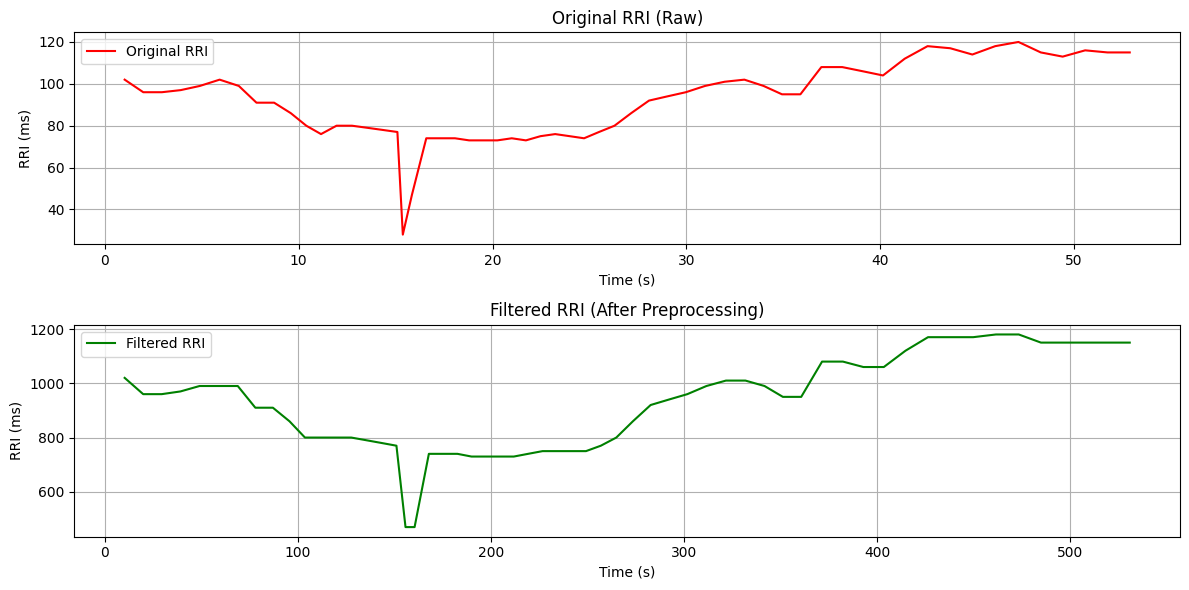

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 예시: rri와 rri_filt 비교
# rri와 rri_filt는 각각 전처리 전과 후의 R-R 간격 값입니다.
# time_rri는 해당 R-R 간격 값들이 발생한 시간 정보입니다.
time_rri = np.cumsum(rri) / FS  # 시간 정보 (초 단위)
time_rri_filt = np.cumsum(rri_filt) / FS  # 전처리된 R-R 간격의 시간 정보

plt.figure(figsize=(12, 6))

# 원시 RRI 시각화
plt.subplot(2, 1, 1)
plt.plot(time_rri, rri, label="Original RRI", color='r')
plt.title('Original RRI (Raw)')
plt.xlabel('Time (s)')
plt.ylabel('RRI (ms)')
plt.grid(True)
plt.legend()

# 필터링된 RRI 시각화
plt.subplot(2, 1, 2)
plt.plot(time_rri_filt, rri_filt, label="Filtered RRI", color='g')
plt.title('Filtered RRI (After Preprocessing)')
plt.xlabel('Time (s)')
plt.ylabel('RRI (ms)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


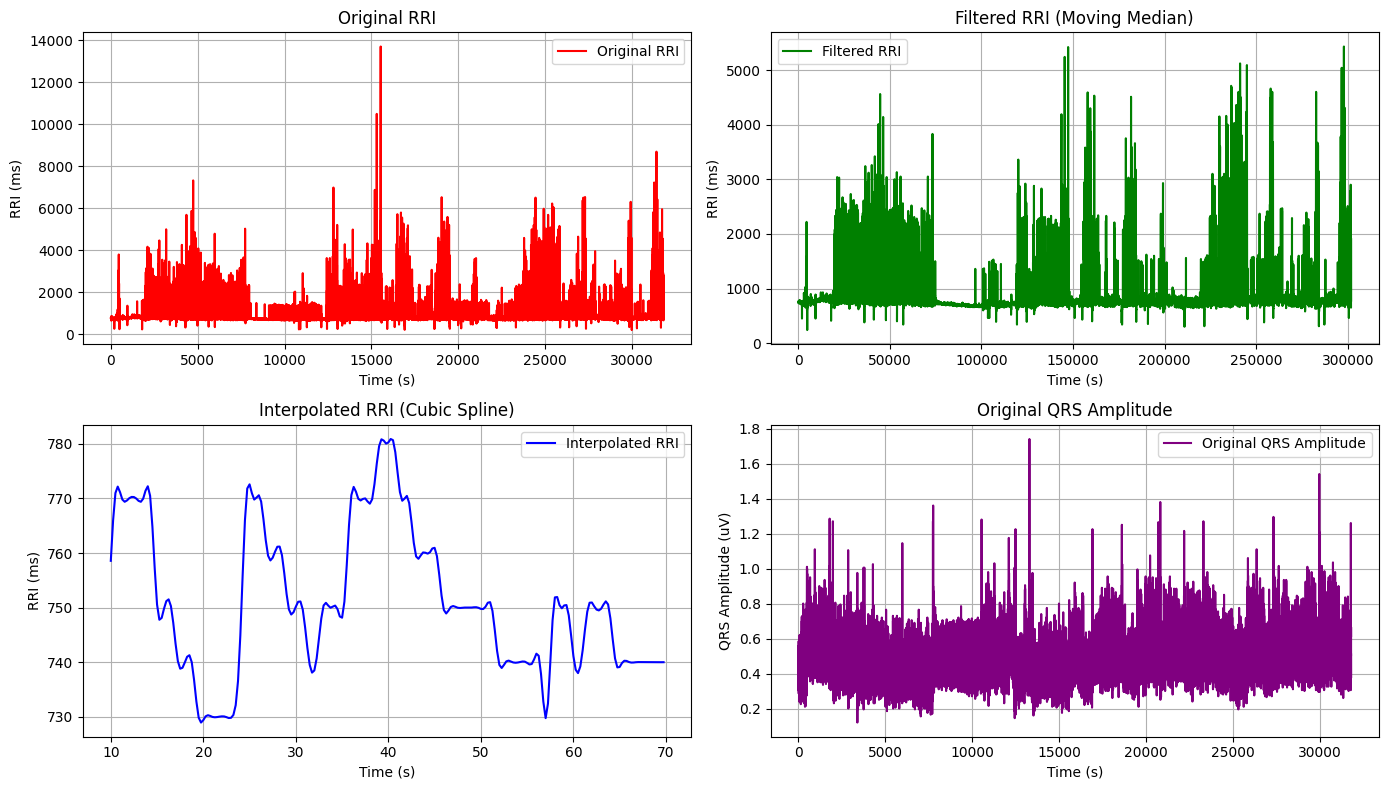

In [ ]:
import wfdb
import matplotlib.pyplot as plt
import numpy as np
from collections.abc import MutableMapping
from hrv.filters import moving_median
from scipy import interpolate
from tqdm import tqdm
import os

# 전처리 코드에서 사용되는 상수들
FS = 100.0  # 원본 샘플링 주파수
FS_INTP = 4  # 보간 후 샘플링 주파수
MARGIN = 10  # 윈도우 마진
MAX_HR = 300.0  # 최대 심박수 (bpm)
MIN_HR = 20.0  # 최소 심박수 (bpm)
MIN_RRI = 1.0 / (MAX_HR / 60.0) * 1000  # 최소 RRI (ms)
MAX_RRI = 1.0 / (MIN_HR / 60.0) * 1000  # 최대 RRI (ms)

# RRI 계산 함수
def create_time_info(rri):
    rri_time = np.cumsum(rri) / 1000.0  # 초 단위로 시간 변환
    return rri_time - rri_time[0]  # 시작점을 0으로 설정

def interp_cubic_spline(rri, fs):
    time_rri = create_time_info(rri)
    time_rri_interp = np.arange(0, time_rri[-1], 1 / float(fs))
    tck = interpolate.splrep(time_rri, rri, s=0)
    rri_interp = interpolate.splev(time_rri_interp, tck, der=0)
    return time_rri_interp, rri_interp

def interp_cubic_spline_qrs(qrs_index, qrs_amp, fs):
    time_qrs = qrs_index / float(FS)  # QRS 위치를 초 단위로 변환
    time_qrs = time_qrs - time_qrs[0]  # 시간 정보를 0부터 시작하도록 조정
    time_qrs_interp = np.arange(0, time_qrs[-1], 1 / float(fs))  # 일정한 주파수의 시간 축 생성
    tck = interpolate.splrep(time_qrs, qrs_amp, s=0)  # 3차 스플라인 함수 생성
    qrs_interp = interpolate.splev(time_qrs_interp, tck, der=0)  # 보간된 QRS 진폭 반환
    return time_qrs_interp, qrs_interp

# QRS 진폭 계산 함수
def get_qrs_amp(ecg, qrs):
    interval = int(FS * 0.250)
    qrs_amp = []
    for index in range(len(qrs)):
        curr_qrs = qrs[index]
        amp = np.max(ecg[curr_qrs - interval:curr_qrs + interval])
        qrs_amp.append(amp)
    return qrs_amp

# 전처리 및 시각화할 데이터 로드 (하나의 파일만 처리)
data_path = '/content/drive/MyDrive/디지털헬스케어/apnea-ecg-database-1.0.0/'
filename = 'a02'  # 처리할 파일 이름 (예시)

# 데이터 로드
signals, fields = wfdb.rdsamp(os.path.join(data_path, filename))
qrs_ann = wfdb.rdann(os.path.join(data_path, filename), 'qrs').sample  # QRS 복합체 위치
apn_ann = wfdb.rdann(os.path.join(data_path, filename), 'apn').symbol  # 아프네아 주석

# 일부 구간 선택 (예: 첫 5분)
samp_from = 0  # 시작 샘플 (0부터 시작)
samp_to = 5 * 60 * FS  # 5분 간격으로 설정 (5분 * FS)

# QRS 진폭 계산
qrs_amp = get_qrs_amp(signals, qrs_ann)

# RRI 계산
rri = np.diff(qrs_ann)
rri_ms = rri.astype('float') / FS * 1000.0  # RRI를 밀리초로 변환

# RRI 필터링 (이동 중앙값 필터)
rri_filt = moving_median(rri_ms)

# 필터링된 RRI 보간
time_intp, rri_intp = interp_cubic_spline(rri_filt, FS_INTP)
qrs_time_intp, qrs_intp = interp_cubic_spline_qrs(qrs_ann, qrs_amp, FS_INTP)

# 전처리 전후 데이터 비교 시각화
# 일부 구간 (1분)만 시각화 (MARGIN을 고려하여 구간을 설정)
time_rri = np.cumsum(rri) / FS
time_rri_filt = np.cumsum(rri_filt) / FS

# 보간된 시간 범위를 원시 RRI와 동일한 시간 범위로 제한
time_rri_intp = time_intp[(time_intp >= MARGIN) & (time_intp < (60 + MARGIN))]
rri_intp = rri_intp[(time_intp >= MARGIN) & (time_intp < (60 + MARGIN))]

# QRS 시간 정보도 동일하게 제한
time_qrs = qrs_ann / FS
time_qrs_intp = qrs_time_intp[(qrs_time_intp >= MARGIN) & (qrs_time_intp < (60 + MARGIN))]
qrs_intp = qrs_intp[(qrs_time_intp >= MARGIN) & (qrs_time_intp < (60 + MARGIN))]

# 시각화
plt.figure(figsize=(14, 8))

# 1. 원시 RRI 시각화
plt.subplot(2, 2, 1)
plt.plot(time_rri, rri_ms, label='Original RRI', color='r')
plt.title('Original RRI')
plt.xlabel('Time (s)')
plt.ylabel('RRI (ms)')
plt.grid(True)
plt.legend()

# 2. 필터링된 RRI 시각화
plt.subplot(2, 2, 2)
plt.plot(time_rri_filt, rri_filt, label='Filtered RRI', color='g')
plt.title('Filtered RRI (Moving Median)')
plt.xlabel('Time (s)')
plt.ylabel('RRI (ms)')
plt.grid(True)
plt.legend()

# 3. 보간된 RRI 시각화
plt.subplot(2, 2, 3)
plt.plot(time_rri_intp, rri_intp, label='Interpolated RRI', color='b')
plt.title('Interpolated RRI (Cubic Spline)')
plt.xlabel('Time (s)')
plt.ylabel('RRI (ms)')
plt.grid(True)
plt.legend()

# 4. 원시 QRS 진폭 시각화
plt.subplot(2, 2, 4)
plt.plot(time_qrs, qrs_amp, label='Original QRS Amplitude', color='purple')
plt.title('Original QRS Amplitude')
plt.xlabel('Time (s)')
plt.ylabel('QRS Amplitude (uV)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


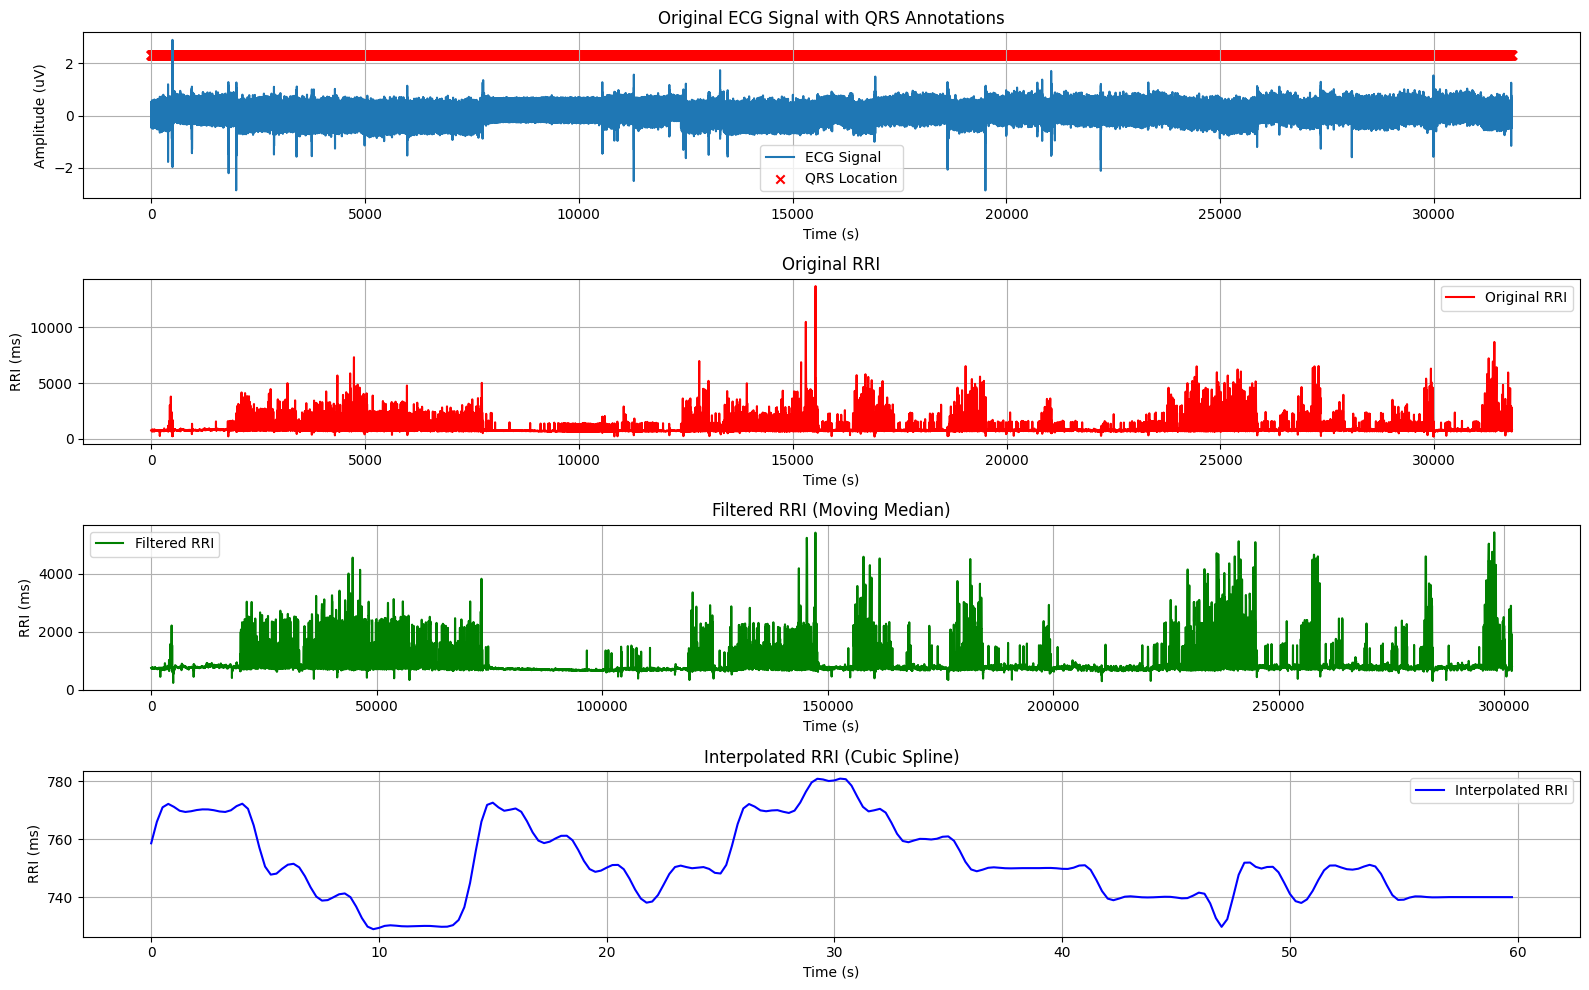

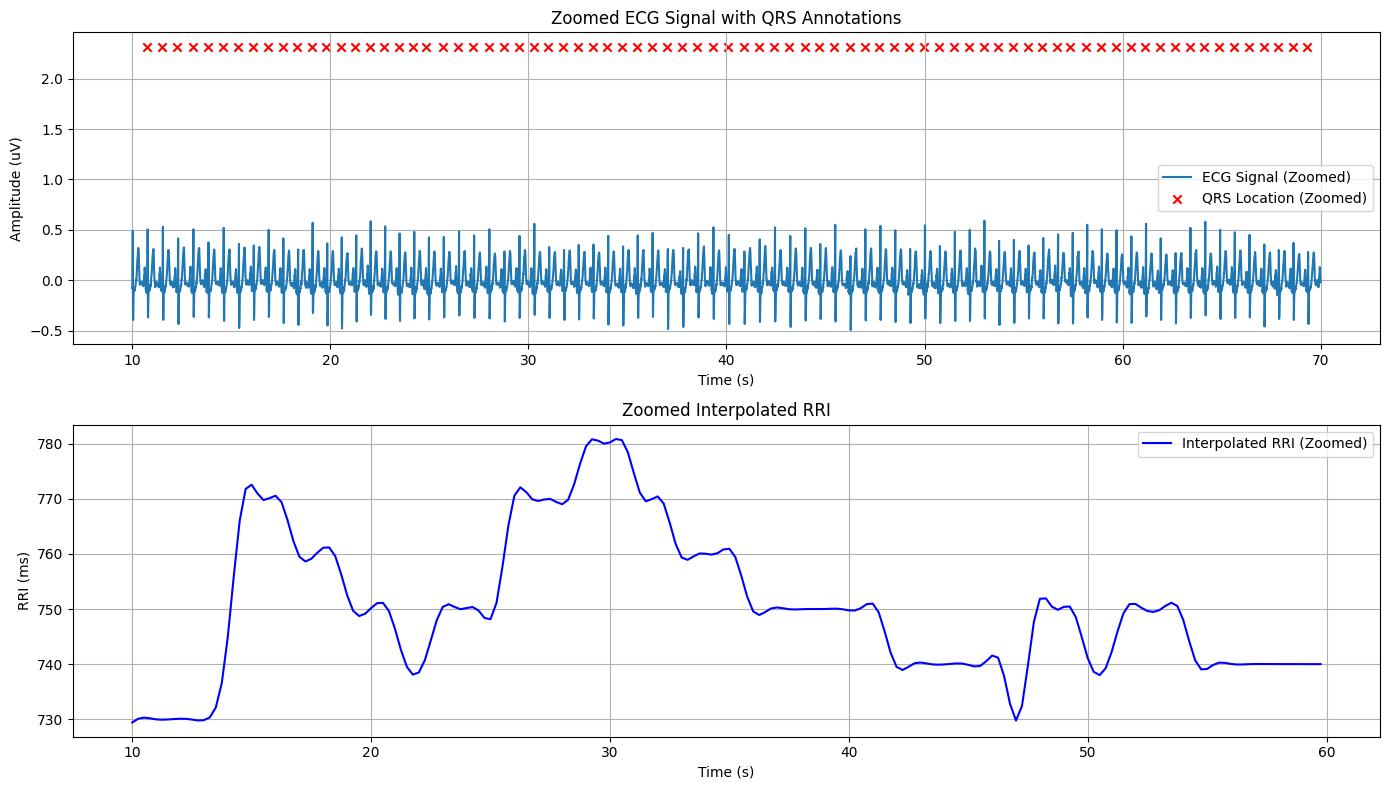

In [ ]:
# 시각화 함수 정의
def visualize_signal_processing(signals, fields, qrs_ann, apn_ann, qrs_amp, rri_ms, rri_filt, rri_intp, qrs_intp, FS, FS_INTP, MARGIN):
    time_ecg = np.arange(signals.shape[0]) / FS  # 원본 ECG 시간 (초 단위)
    time_qrs = qrs_ann / FS  # QRS 위치 (초 단위)
    time_rri = np.cumsum(np.diff(qrs_ann)) / FS  # 원본 RRI 시간
    time_rri_filt = np.cumsum(rri_filt) / FS  # 필터링된 RRI 시간
    time_intp = np.arange(0, len(rri_intp)) / FS_INTP  # 보간된 시간 (초 단위)
    time_qrs_intp = np.arange(0, len(qrs_intp)) / FS_INTP  # 보간된 QRS 시간 (초 단위)

    # 1. 전체 신호 시각화
    plt.figure(figsize=(16, 10))

    plt.subplot(4, 1, 1)
    plt.plot(time_ecg, signals[:, 0], label='ECG Signal')
    plt.scatter(time_qrs, np.ones_like(time_qrs) * max(signals[:, 0]) * 0.8, color='r', label='QRS Location', marker='x')
    plt.title('Original ECG Signal with QRS Annotations')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (uV)')
    plt.legend()
    plt.grid(True)

    plt.subplot(4, 1, 2)
    plt.plot(time_rri, rri_ms, label='Original RRI', color='r')
    plt.title('Original RRI')
    plt.xlabel('Time (s)')
    plt.ylabel('RRI (ms)')
    plt.legend()
    plt.grid(True)

    plt.subplot(4, 1, 3)
    plt.plot(time_rri_filt, rri_filt, label='Filtered RRI', color='g')
    plt.title('Filtered RRI (Moving Median)')
    plt.xlabel('Time (s)')
    plt.ylabel('RRI (ms)')
    plt.legend()
    plt.grid(True)

    plt.subplot(4, 1, 4)
    plt.plot(time_intp, rri_intp, label='Interpolated RRI', color='b')
    plt.title('Interpolated RRI (Cubic Spline)')
    plt.xlabel('Time (s)')
    plt.ylabel('RRI (ms)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # 2. 일부 구간 확대 시각화 (예: 1분)
    start_idx = int(MARGIN * FS)
    end_idx = int((60 + MARGIN) * FS)
    time_short = time_ecg[start_idx:end_idx]

    plt.figure(figsize=(14, 8))

    plt.subplot(2, 1, 1)
    plt.plot(time_short, signals[start_idx:end_idx, 0], label='ECG Signal (Zoomed)')
    plt.scatter(time_qrs[(time_qrs >= MARGIN) & (time_qrs < (60 + MARGIN))],
                np.ones_like(time_qrs[(time_qrs >= MARGIN) & (time_qrs < (60 + MARGIN))]) * max(signals[:, 0]) * 0.8,
                color='r', label='QRS Location (Zoomed)', marker='x')
    plt.title('Zoomed ECG Signal with QRS Annotations')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (uV)')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(time_intp[(time_intp >= MARGIN) & (time_intp < (60 + MARGIN))],
             rri_intp[(time_intp >= MARGIN) & (time_intp < (60 + MARGIN))],
             label='Interpolated RRI (Zoomed)', color='b')
    plt.title('Zoomed Interpolated RRI')
    plt.xlabel('Time (s)')
    plt.ylabel('RRI (ms)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


# 시각화 함수 호출
visualize_signal_processing(
    signals, fields, qrs_ann, apn_ann, qrs_amp, rri_ms, rri_filt, rri_intp, qrs_intp, FS, FS_INTP, MARGIN
)


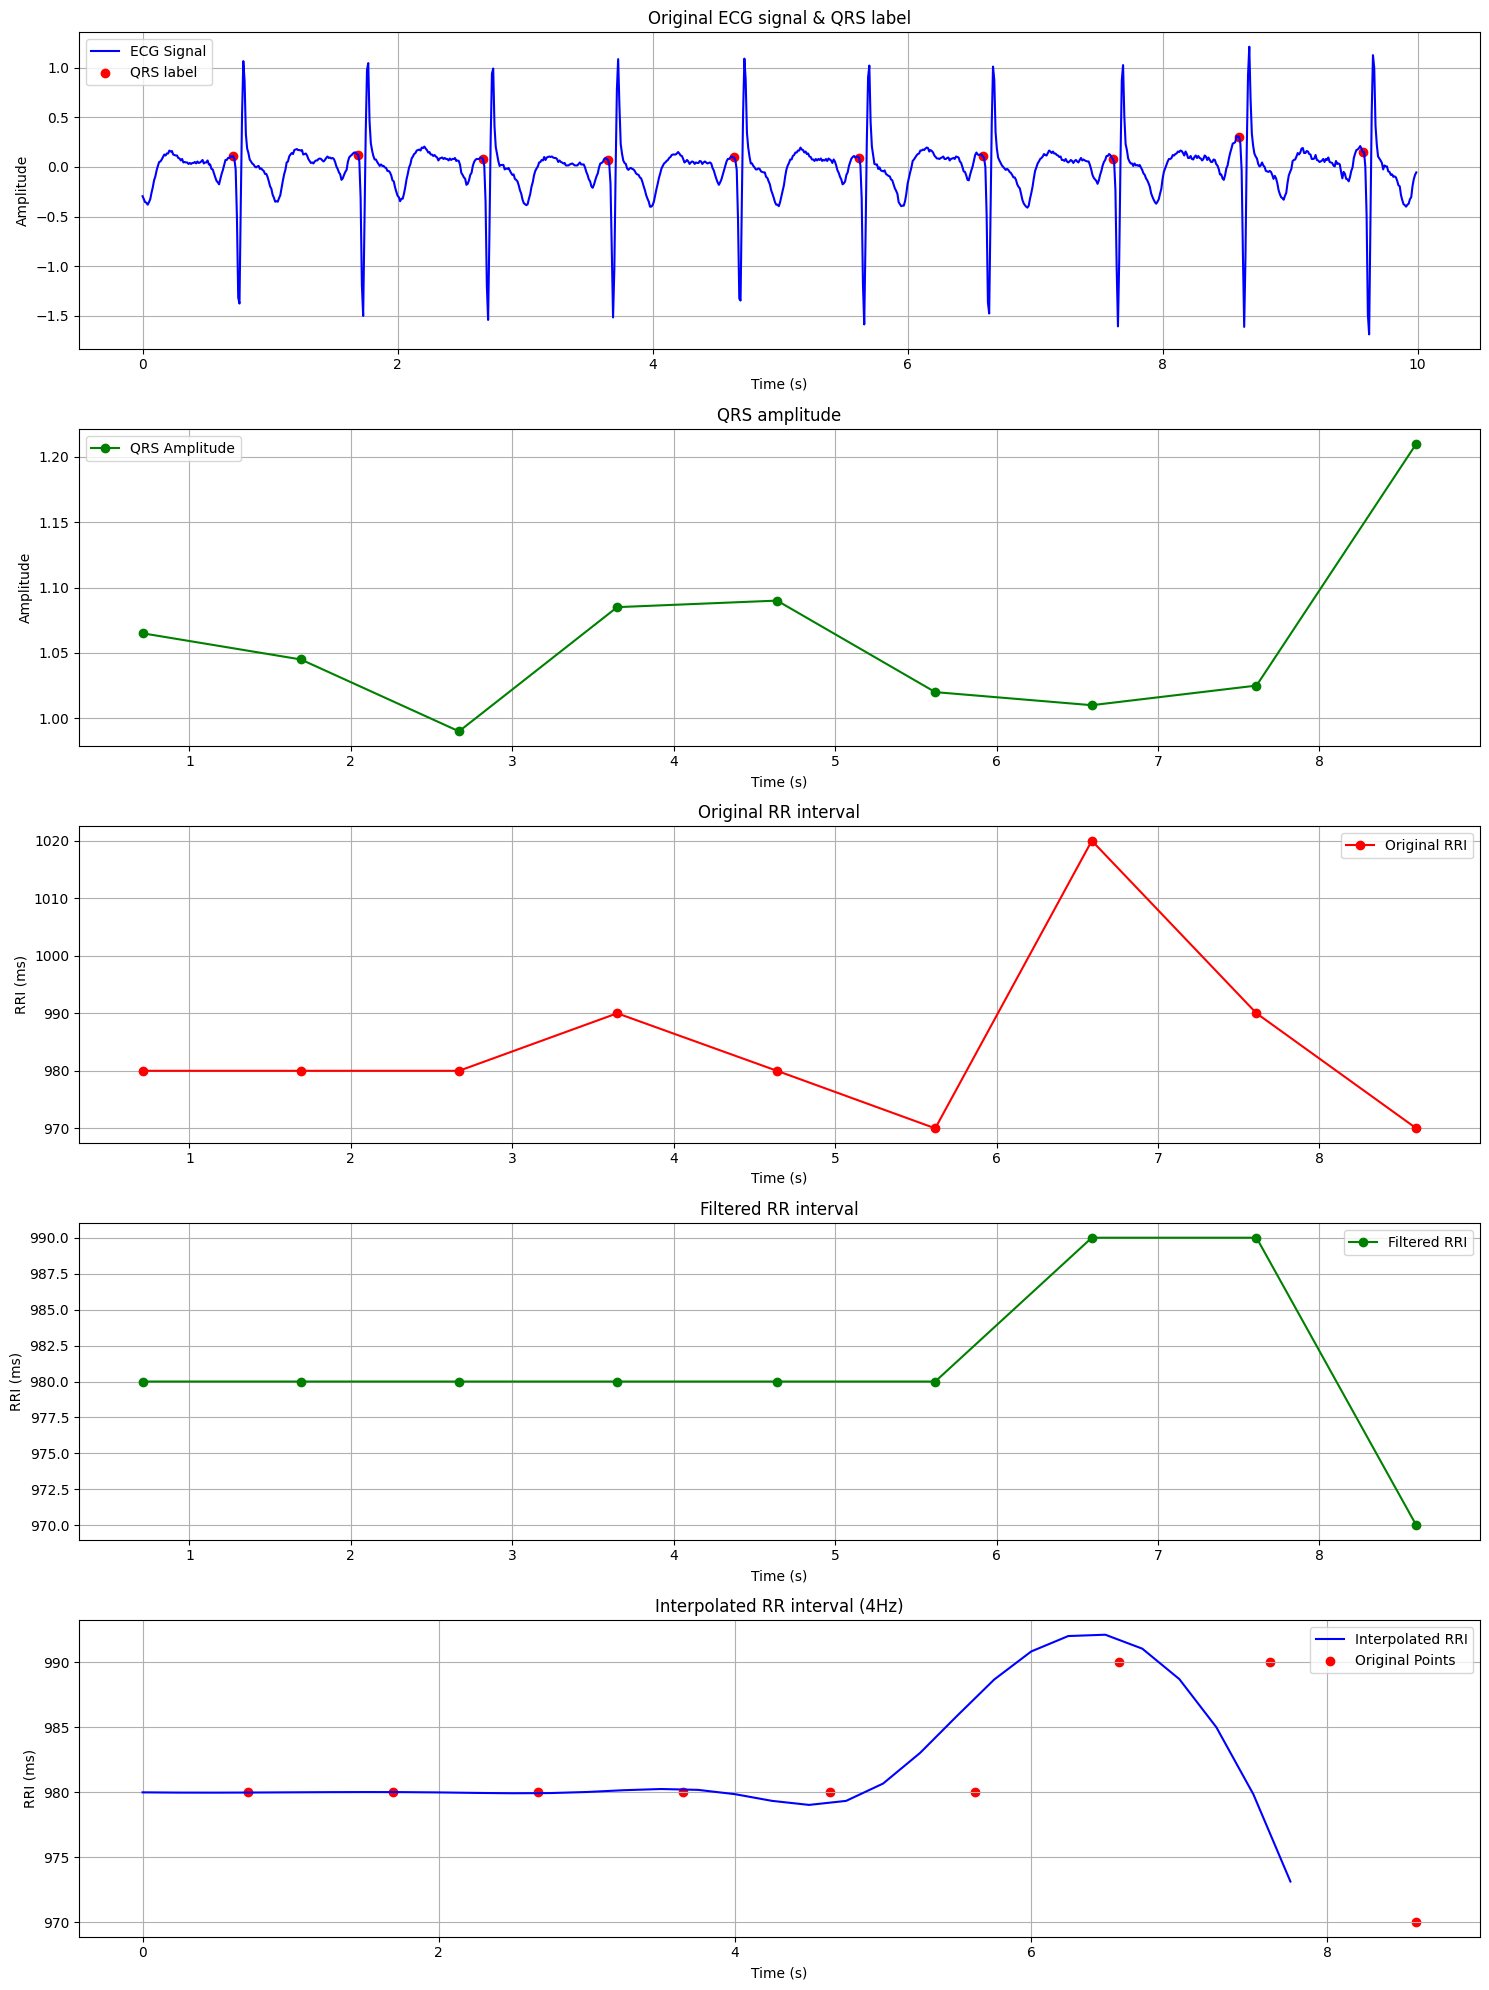

In [ ]:
import wfdb
import matplotlib.pyplot as plt
import numpy as np
from hrv.filters import moving_median
from scipy import interpolate

def visualize_preprocessing(data_path, record_name, start_time=0, duration=10):
    # 상수 정의
    FS = 100.0  # 샘플링 주파수
    FS_INTP = 4  # 보간 주파수
    MARGIN = 10  # 마진 (초)

    # 시간 범위 계산
    samp_from = int(start_time * FS)
    samp_to = int((start_time + duration) * FS)
    margin_samples = int(MARGIN * FS)

    # 마진을 고려한 시작점이 음수가 되지 않도록 조정
    effective_start = max(0, samp_from - margin_samples)

    # 1. 원본 데이터 로드
    signals, fields = wfdb.rdsamp(f"{data_path}/{record_name}", sampfrom=samp_from, sampto=samp_to)
    time = np.arange(len(signals)) / FS

    # 2. QRS 주석 로드
    qrs_ann = wfdb.rdann(f"{data_path}/{record_name}", 'qrs',
                        sampfrom=effective_start,
                        sampto=samp_to + margin_samples).sample

    # 3. 무호흡 주석 로드
    apn_ann = wfdb.rdann(f"{data_path}/{record_name}", 'apn',
                        sampfrom=samp_from,
                        sampto=samp_to-1).symbol

    # QRS 진폭 계산
    def get_qrs_amp(ecg, qrs):
        interval = int(FS * 0.250)
        qrs_amp = []
        for index in range(len(qrs)):
            curr_qrs = qrs[index]
            # 범위를 벗어나지 않도록 보호
            start_idx = max(0, curr_qrs-interval)
            end_idx = min(len(ecg), curr_qrs+interval)
            amp = np.max(ecg[start_idx:end_idx])
            qrs_amp.append(amp)
        return qrs_amp

    # 상대적 QRS 위치 계산 및 관심 구간 내의 QRS만 선택
    qrs_relative = qrs_ann - samp_from
    valid_qrs_mask = (qrs_relative >= 0) & (qrs_relative < len(signals))
    qrs_relative = qrs_relative[valid_qrs_mask]

    # RRI 계산
    rri = np.diff(qrs_ann[valid_qrs_mask])
    rri_ms = rri.astype('float') / FS * 1000.0

    # QRS 진폭 계산
    qrs_amp = get_qrs_amp(signals.flatten(), qrs_relative)

    # RRI 필터링
    rri_filt = moving_median(rri_ms)

    # 충분한 데이터가 있는지 확인
    if len(rri_filt) < 2:
        raise ValueError("선택한 구간에 충분한 QRS 데이터가 없습니다. 다른 구간을 선택해주세요.")

    # 보간
    def create_time_info(rri):
        rri_time = np.cumsum(rri) / 1000.0
        return rri_time - rri_time[0]

    def create_interp_time(rri, fs):
        time_rri = create_time_info(rri)
        return np.arange(0, time_rri[-1], 1 / float(fs))

    time_rri = create_time_info(rri_filt)
    time_intp = create_interp_time(rri_filt, FS_INTP)
    tck = interpolate.splrep(time_rri, rri_filt, s=0)
    rri_intp = interpolate.splev(time_intp, tck, der=0)

    # 그래프 그리기
    fig, axs = plt.subplots(5, 1, figsize=(15, 20))

    # 1. 원본 ECG 신호 + QRS 위치
    axs[0].plot(time, signals, 'b-', label='ECG Signal')
    axs[0].scatter(qrs_relative/FS, [signals.flatten()[i] for i in qrs_relative],
                  color='red', label='QRS label')
    axs[0].set_title('Original ECG signal & QRS label')
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Amplitude')
    axs[0].legend()
    axs[0].grid(True)

    # 2. QRS 진폭
    qrs_time = qrs_relative[:-1] / FS  # QRS 발생 시간
    axs[1].plot(qrs_time, qrs_amp[:-1], 'g-o', label='QRS Amplitude')
    axs[1].set_title('QRS amplitude')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Amplitude')
    axs[1].legend()
    axs[1].grid(True)

    # 3. 원본 RRI
    axs[2].plot(qrs_time, rri_ms, 'r-o', label='Original RRI')
    axs[2].set_title('Original RR interval')
    axs[2].set_xlabel('Time (s)')
    axs[2].set_ylabel('RRI (ms)')
    axs[2].legend()
    axs[2].grid(True)

    # 4. 필터링된 RRI
    axs[3].plot(qrs_time, rri_filt, 'g-o', label='Filtered RRI')
    axs[3].set_title('Filtered RR interval')
    axs[3].set_xlabel('Time (s)')
    axs[3].set_ylabel('RRI (ms)')
    axs[3].legend()
    axs[3].grid(True)

    # 5. 보간된 RRI
    axs[4].plot(time_intp, rri_intp, 'b-', label='Interpolated RRI')
    axs[4].scatter(qrs_time, rri_filt, color='red', label='Original Points')
    axs[4].set_title('Interpolated RR interval (4Hz)')
    axs[4].set_xlabel('Time (s)')
    axs[4].set_ylabel('RRI (ms)')
    axs[4].legend()
    axs[4].grid(True)

    plt.tight_layout()
    plt.show()

# 사용 예시
data_path = '/content/drive/MyDrive/디지털헬스케어/apnea-ecg-database-1.0.0'
record_name = 'a10'
visualize_preprocessing(data_path, record_name, start_time=10, duration=10)  # 시작 시간을 10초로 변경

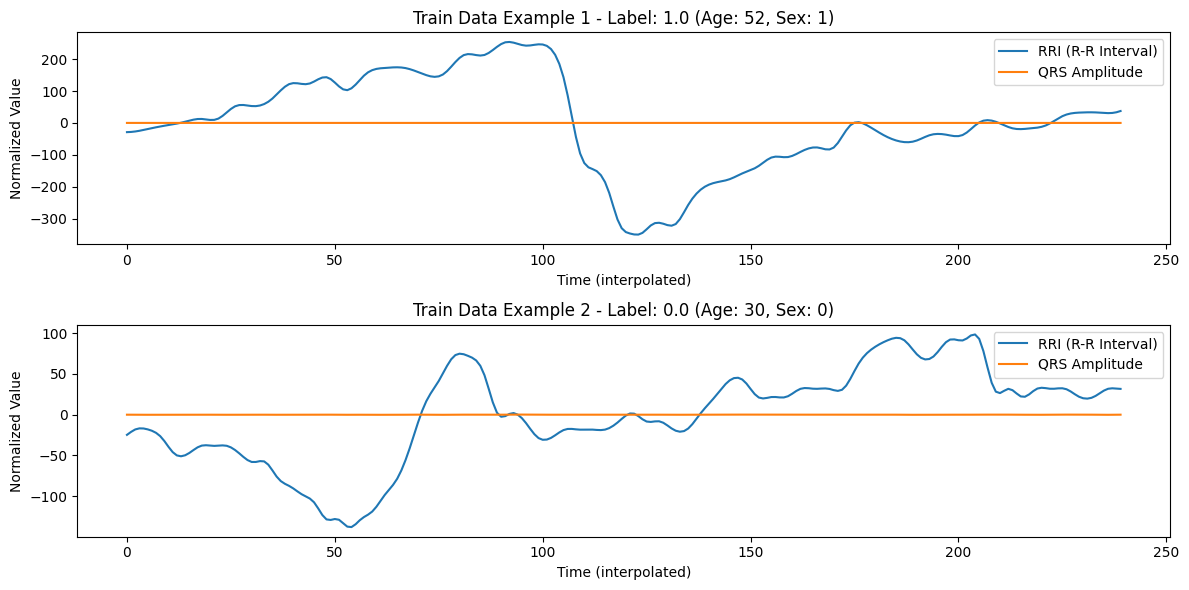

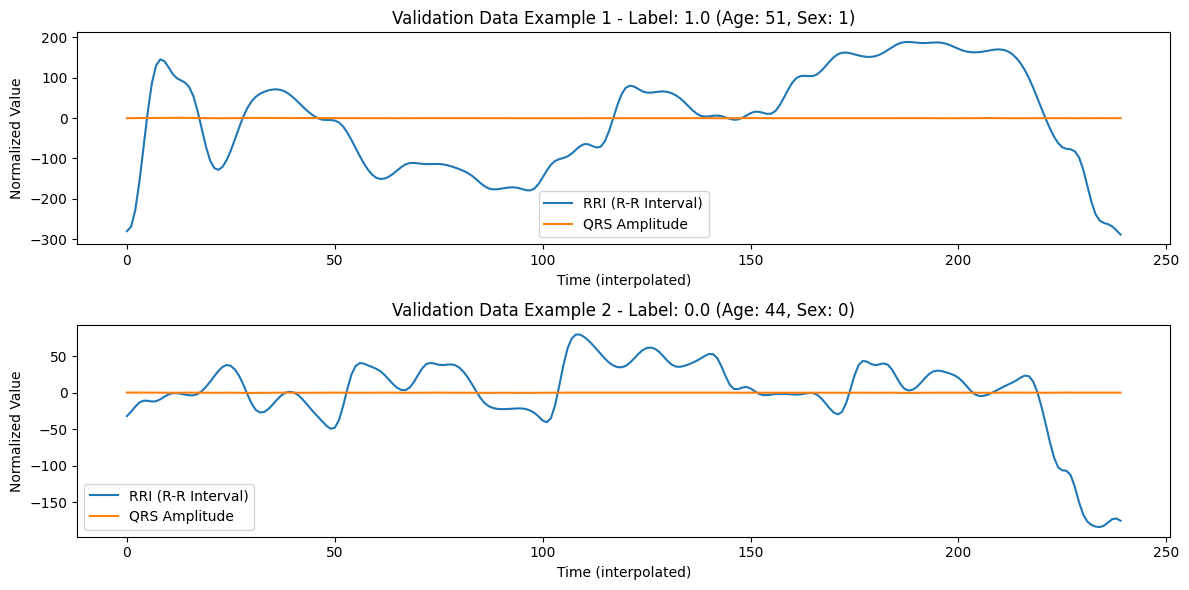

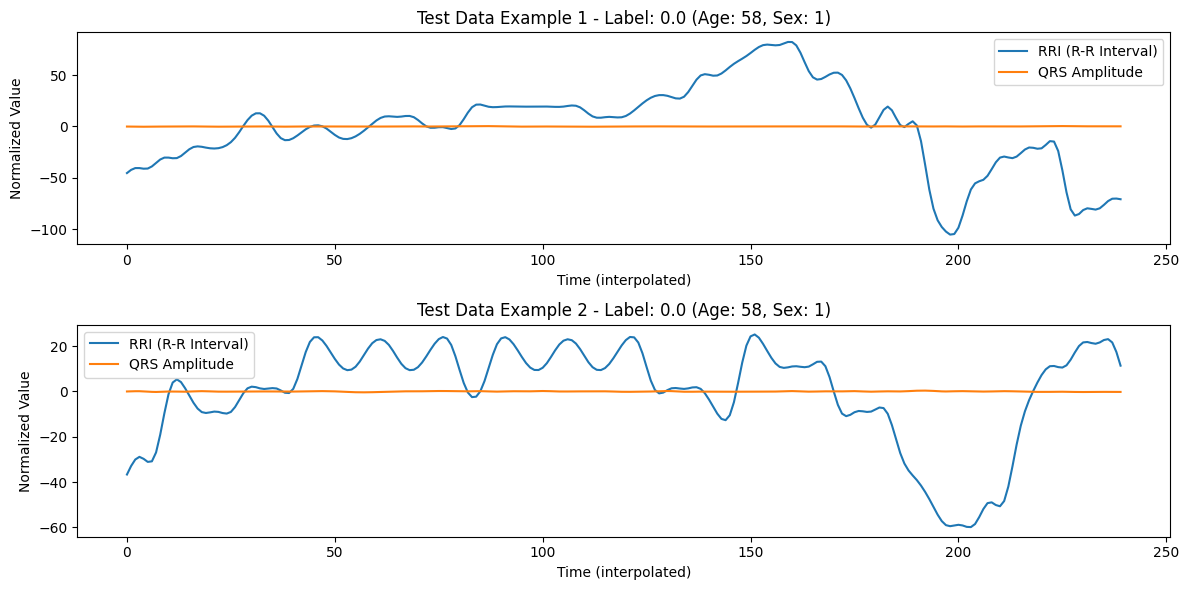

In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random

# Load data
def load_data(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f)

train_data = load_data('/content/drive/MyDrive/디지털헬스케어/train_input.pickle')
train_labels = load_data('/content/drive/MyDrive/디지털헬스케어/train_label.pickle')
val_data = load_data('/content/drive/MyDrive/디지털헬스케어/val_input.pickle')
val_labels = load_data('/content/drive/MyDrive/디지털헬스케어/val_label.pickle')
test_data = load_data('/content/drive/MyDrive/디지털헬스케어/test_input.pickle')
test_labels = load_data('/content/drive/MyDrive/디지털헬스케어/test_label.pickle')


# Visualization function
def visualize_data(data, labels, title, num_samples=2):
    plt.figure(figsize=(12, 6))
    indices = random.sample(range(len(data)), num_samples)
    for i, idx in enumerate(indices):
    #for i in range(min(num_samples, len(data))):  # Visualize the first 3 examples
        rri, qrs, age, sex = data[idx]  # Extract features
        plt.subplot(num_samples, 1, i + 1)
        plt.plot(rri, label="RRI (R-R Interval)")
        plt.plot(qrs, label="QRS Amplitude")
        plt.title(f"{title} Example {i+1} - Label: {labels[idx]} (Age: {age}, Sex: {sex})")
        plt.xlabel("Time (interpolated)")
        plt.ylabel("Normalized Value")
        plt.legend()
    plt.tight_layout()
    plt.show()

# Visualize each dataset
visualize_data(train_data, train_labels, "Train Data")
visualize_data(val_data, val_labels, "Validation Data")
visualize_data(test_data, test_labels, "Test Data")

##### FS_INTP = 4 Hz는 초당 4개의 샘플 -> 60초 동안 240개의 데이터 포인트로 보간됨

# 모델 학습

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time
import tensorflow as tf
import pickle
import wfdb
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

# Hyper-parameters
sequence_length = 240
epochs = 1000#int(input('Enter Number of Epochs (or enter default 1000): '))
FS = 100.0

def z_norm(result):
    result_mean = np.mean(result)
    result_std = np.std(result)
    result = (result - result_mean) / result_std
    return result

def split_data(X):
    X1 = []
    X2 = []
    for index in range(len(X)):
        X1.append([X[index][0], X[index][1]])
        X2.append([X[index][2], X[index][3]])

    return np.array(X1).astype('float64'), np.array(X2).astype('float64')

def get_data():
    with open('/content/drive/MyDrive/디지털헬스케어/train_input.pickle','rb') as f:
        X_train = np.asarray(pickle.load(f), dtype=object)
    with open('/content/drive/MyDrive/디지털헬스케어/train_label.pickle','rb') as f:
        y_train = np.asarray(pickle.load(f))
    with open('/content/drive/MyDrive/디지털헬스케어/val_input.pickle','rb') as f:
        X_val = np.asarray(pickle.load(f), dtype=object)
    with open('/content/drive/MyDrive/디지털헬스케어/val_label.pickle','rb') as f:
        y_val = np.asarray(pickle.load(f))
    with open('/content/drive/MyDrive/디지털헬스케어/test_input.pickle','rb') as f:
        X_test = np.asarray(pickle.load(f), dtype=object)
    with open('/content/drive/MyDrive/디지털헬스케어/test_label.pickle','rb') as f:
        y_test = np.asarray(pickle.load(f))


    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    '''
    X_train = X_train[:, 0, :]
    X_test = X_test[:, 0, :]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    '''
    X_train1, X_train2 = split_data(X_train)
    X_val1, X_val2 = split_data(X_val)
    X_test1, X_test2 = split_data(X_test)

    X_train1 = np.transpose(X_train1, (0, 2, 1))
    #X_train2 = np.reshape(X_train2, (X_train2.shape[0], X_train2.shape[1], 1))
    X_test1 = np.transpose(X_test1, (0, 2, 1))
    #X_test2 = np.reshape(X_test2, (X_test2.shape[0], X_test2.shape[1], 1))
    X_val1 = np.transpose(X_val1, (0, 2, 1))
    return X_train1, X_train2, y_train, X_val1, X_val2, y_val, X_test1, X_test2, y_test



def build_model():

    layers = {'input': 2, 'hidden1': 256, 'hidden2': 256, 'hidden3': 256, 'output': 1}
    x1 = tf.keras.layers.Input(shape=(sequence_length, layers['input']))
    m1 = tf.keras.layers.LSTM(layers['hidden1'],
                    recurrent_dropout=0.5,
                   return_sequences=True)(x1)
    m1 = tf.keras.layers.LSTM(
            layers['hidden2'],
            recurrent_dropout=0.5,
            return_sequences=True)(m1)

    m1 = tf.keras.layers.LSTM(
            layers['hidden3'],
            recurrent_dropout=0.5,
            return_sequences=False)(m1)

    x2 = tf.keras.layers.Input(shape=(2,))
    m2 = tf.keras.layers.Dense(32)(x2)

    #merged = Merge([model1, model2], mode='concat')
    merged = tf.keras.layers.Concatenate(axis=1)([m1, m2])

    out = tf.keras.layers.Dense(8)(merged)
    out = tf.keras.layers.Dense(layers['output'], kernel_initializer='normal')(out)
    out = tf.keras.layers.Activation("sigmoid")(out)

    model = tf.keras.models.Model(inputs=[x1, x2], outputs=[out])

    start = time.time()
    model.compile(loss="binary_crossentropy", optimizer="adam",
                  metrics = ['accuracy'])
    print ("Compilation Time : ", time.time() - start)

    model.summary()
    return model


def run_network(model=None, data=None):
    global_start_time = time.time()

    print ('\nData Loaded. Compiling...\n')
    print('Loading data... ')
    X_train1, X_train2, y_train, X_val1, X_val2, y_val, X_test1, X_test2, y_test = get_data()

    class_w = class_weight.compute_class_weight(class_weight='balanced',
                                                     classes=np.unique(y_train),
                                                     y=y_train)

    print (class_w)

    if model is None:
        model = build_model()

    try:
        print("Training")

        class_w = {i : class_w[i] for i in range(2)}
        callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
        history = model.fit([X_train1, X_train2], y_train,
                            validation_data=([X_val1, X_val2], y_val),
                            callbacks=[callback],
                             epochs=epochs, batch_size=256, class_weight=class_w)

        import matplotlib.pyplot as plt
        '''
        plt.plot(history.losses)
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train'], loc='upper left')
        plt.show()
        '''
        # Evaluate Model
        y_pred = model.predict([X_test1, X_test2])
        scores = model.evaluate([X_test1, X_test2], y_test)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))


    except KeyboardInterrupt:
        print("prediction exception")
        print ('Training duration (s) : ', time.time() - global_start_time)
        return model


    print ('Training duration (s) : ', time.time() - global_start_time)

    return model

run_network()


Data Loaded. Compiling...

Loading data... 
[0.82091433 1.27902412]
Compilation Time :  0.00493621826171875


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 240, 2)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ (None, 240, 256)       │        265,216 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_4 (LSTM)             │ (None, 240, 256)       │        525,312 │ lstm_3[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 2)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_5 (LSTM)             │ (None, 256)            │        525,312 │ lstm_4[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 32)             │             96 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 288)            │              0 │ lstm_5[0][0],          │
│ (Concatenate)             │                        │                │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 8)              │          2,312 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1)              │              9 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 1)              │              0 │ dense_5[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,318,257 (5.03 MB)

 Trainable params: 1,318,257 (5.03 MB)

 Non-trainable params: 0 (0.00 B)

Training
Epoch 1/1000
54/54 ━━━━━━━━━━━━━━━━━━━━ 774s 14s/step - accuracy: 0.6222 - loss: 0.6562 - val_accuracy: 0.6577 - val_loss: 0.6054
Epoch 2/1000
21/54 ━━━━━━━━━━━━━━━━━━━━ 7:23 13s/step - accuracy: 0.6493 - loss: 0.6246prediction exception
Training duration (s) :  1070.3291504383087


<Functional name=functional_1, built=True>